# Sample Dataverse API useage in Python

In [1]:
%matplotlib inline

import requests
import json
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def pretty(data):
    return json.dumps(data, indent=4)  

## You must have your own API token.
### Setup your own token for dataverse here: https://dataverse.ada.edu.au/account/apitoken

In [1]:
token = ''  # Generated at /account/apitoken
headers = {'X-Dataverse-key' : token}

Browse the dataverse first to find you dataset and use the DOI of the dataset.
In this example we are using a dataset published by Prosecution Project https://prosecutionproject.griffith.edu.au
http://dx.doi.org/10.26193/VQVKYY

In [5]:
# Get the dataset by doi
url = 'https://dataverse.ada.edu.au/api/datasets/:persistentId/?persistentId=doi:10.26193/U3ZZGY'
r1 = requests.get(url, headers = headers)
data = json.loads(r1.content).get('data')
# print(data)

# Get the files for dataset with specified dataset id
# Extract the dataset id
dsid  = data.get('id')
url = 'https://dataverse.ada.edu.au/api/datasets/{id}/versions/:latest/files'.format(id=dsid)
r1 = requests.get(url, headers = headers)
data = json.loads(r1.content).get('data')
# print(data)

fileid = data[1].get('dataFile').get('id')
url = 'https://dataverse.ada.edu.au/api/access/datafile/{id}?format=original'.format(id=fileid)
# r1 = requests.get(url, headers = headers)
df = pd.read_csv(url)

#print('COLUMNS: {}'.format(pretty(list(df.columns))))

In [ ]:
In this example we will find all Judges and all the verdicts they have handed down.

In [6]:
# filter nan
df = df[df.trial_judge.notnull()]
df = df[df.verdict.notnull()]

JUDGES = df.trial_judge.unique()
#print('Judges: {}\n'.format(pretty(list(JUDGES))))

VERDICTS = df.verdict.unique()
#print('Verdicts: {}\n'.format(pretty(list(VERDICTS))))

NOT_GUILTY = [
    'DISMISSED',
    'NOT GUILTY BY DIRECTION',
    'NOT GUILTY',
    'NOLLE PROSEQUI',
    'JURY - INSUFFICIENT EVIDENCE - DISCHARGED',
    'ADJOURNED',
    'JURY THREW OUT CASE ON THE BASIS OF CONFLICTING EVIDENCE'
]


In [7]:
judge_verdicts = {}
for judge in JUDGES:
    not_guilty_df = df[(df.trial_judge == judge) & (df.verdict.isin(NOT_GUILTY))]
    guilty_df = df[(df.trial_judge == judge) & (~df.verdict.isin(NOT_GUILTY))]
#     print('COUNT: ', len(guilty_df.index))
    judge_verdicts[judge] = {
        'total': len(not_guilty_df.index) + len(guilty_df.index),
        'guilty': len(guilty_df.index),
        'not_guilty': len(not_guilty_df.index)
    }
#    print('{}: {}'.format(judge, judge_verdicts[judge]))


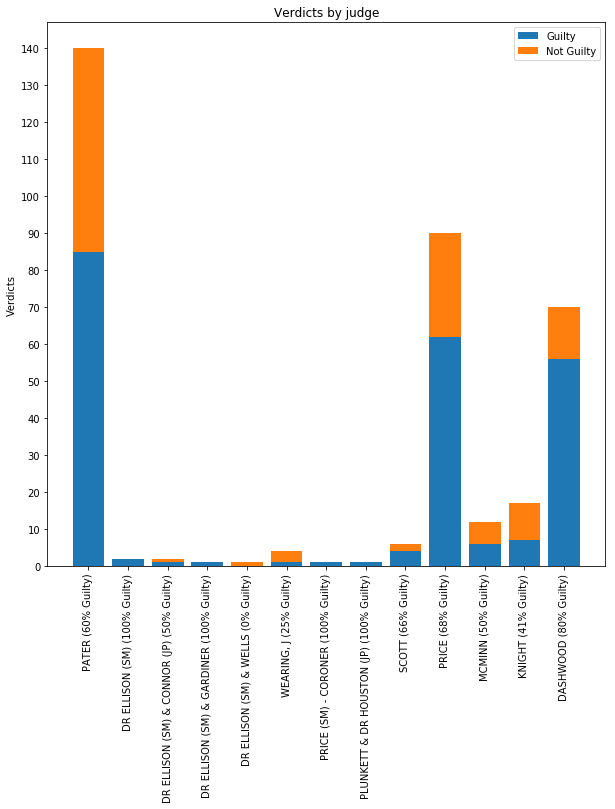

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)

width = .8
n_cols = len(JUDGES)
x_idx = [x for x in range(n_cols)]
y_ceil = max([x['total'] for x in judge_verdicts.values()]) + 1
y_idx = [x for x in range(0, y_ceil, 10)]

guilty_verdicts = [x['guilty'] for x in judge_verdicts.values()]
not_guilty_verdicts = [x['not_guilty'] for x in judge_verdicts.values()]

p1 = plt.bar(
    x_idx,
    guilty_verdicts,
    width
)
p2 = plt.bar(
    x_idx,
    not_guilty_verdicts,
    width,
    bottom=guilty_verdicts
)

plt.ylabel('Verdicts')
plt.title('Verdicts by judge')
plt.xticks(
    x_idx,
    [
        '{} ({}% Guilty)'.format(
            k,
            int(v['guilty']/v['total'] * 100)
        )
        for k, v in judge_verdicts.items()
    ],
    rotation=90
)
plt.yticks(y_idx)
plt.legend((p1[0], p2[0]), ('Guilty', 'Not Guilty'))
# plt.figure(figsize=(100,100))